In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, scale
from os import listdir
import keras
import squarify
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 1000) 

Using TensorFlow backend.


In [2]:
pd.options.display.max_columns = None
frames = []
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]
def find_soccer_files(dirname):
    filenames = find_csv_filenames(dirname)
    for name in filenames:
        try:
            name = dirname + name
            df = pd.read_csv(name, engine='python')
            #print('The shape is' + str(df.shape) + 'in the file' + name)
            df = (df[['Div', 'HomeTeam', 'AwayTeam',
                    'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
                    'HTR', 'HS', 'AS', 'HST', 'AST',
                    'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']])
            #print('The new shape is' + str(df.shape) + 'in the file' + name)
            frames.append(df)
        except Exception as error:
            print(error)
            
find_soccer_files('premier_league/')
find_soccer_files('eng_championship/')            
df1 = pd.concat(frames)
print(df1.shape)
df1.head()

(12118, 21)


,Div,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0
1,E0,Everton,Man United,0.0,2.0,A,0.0,1.0,A,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0
2,E0,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,15.0,7.0,7.0,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0
3,E0,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,15.0,13.0,8.0,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0
4,E0,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,4.0,16.0,2.0,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0


In [3]:
#Home teams played array
ht = []
#Home team wins array
htw = []


df1['home_team_chance_to_draw_home'] = 0.0
df1['home_team_chance_to_win_home'] = 0.0
df1['home_team_chance_to_lose_home'] = 0.0
df1['home_team_chance_to_win_agaisnt_away'] = 0.0
df1['home_team_chance_to_draw_agaisnt_away'] = 0.0
df1['home_team_chance_to_lose_agaisnt_away'] = 0.0
for home_team, away_team in zip(df1['HomeTeam'].unique(), df1['AwayTeam'].unique()):
    # Times each team played as home team
    played_ht = len(df1.loc[df1['HomeTeam'] == home_team, ['HomeTeam', 'FTR']])

    
    
    # Times each team draw as a home team
    played_htd = len(df1.loc[(df1['HomeTeam'] == home_team) & (df1['FTR'] == 'D'), ['HomeTeam', 'FTR']])

        
    played_htd = len(df1.loc[(df1['HomeTeam'] == home_team) & (df1['FTR'] == 'A'), ['HomeTeam', 'FTR']])
    
    # Times each team won as a home team
    played_htw = len(df1.loc[(df1['HomeTeam'] == home_team) & (df1['FTR'] == 'H'), ['HomeTeam', 'FTR']])
    if str(home_team).lower() == 'nan':
        continue
        
    #print('Percentage of', home_team, 'winning is' , str( "%.2f" % ((played_htw / played_ht) * 100) + '%'), 'playing at home')

    home_team_draw_percentage = df1.loc[df1['HomeTeam'] == home_team, ['home_team_chance_to_draw_home']] = float("%.2f" % ((played_htd / played_ht)))
    home_team_win_percentage = df1.loc[df1['HomeTeam'] == home_team, ['home_team_chance_to_win_home']] = float("%.2f" % ((played_htw / played_ht)))
    home_team_lose_percentage = df1.loc[df1['HomeTeam'] == home_team, ['home_team_chance_to_lose_home']] = float("%.2f" % ((played_htw / played_ht)))
    
    # Ammount of times the home team played agaisn't Away Team
    home_team_played_agaisnt_away = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team), ['HomeTeam', 'AwayTeam', 'FTR']]
    
    
    home_team_draw_agaisnt_away = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'D'), ['HomeTeam', 'AwayTeam', 'FTR']]
    
    home_team_win_agaisnt_away = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'H'), ['HomeTeam', 'AwayTeam', 'FTR']]
    home_team_lose_agaisnt_away = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'A'), ['HomeTeam', 'AwayTeam', 'FTR']]
    #print(home_team_win_agaisnt_away)
    if len(home_team_played_agaisnt_away) == 0:
        continue
        
    df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'H'), ['home_team_chance_to_win_agaisnt_away']] = len(home_team_win_agaisnt_away) / len(home_team_played_agaisnt_away)
    df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'D'), ['home_team_chance_to_draw_agaisnt_away']] = len(home_team_draw_agaisnt_away) / len(home_team_played_agaisnt_away)
    df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] == 'A'), ['home_team_chance_to_lose_agaisnt_away']] = len(home_team_lose_agaisnt_away) / len(home_team_played_agaisnt_away)
    #print(home_team_win_percentage)
    #home_team_win_percentage = df1.loc[(df1['HomeTeam'] == home_team) & (df1['AwayTeam'] == away_team) & (df1['FTR'] != 'H'), ['home_team_chance_to_win_agaisnt_away']] = 0

#df1.head(20)

In [4]:
games = df1
games['HTR'] = games['HTR'].replace('H', 2).replace('D', 1).replace('A', 0)
games['FTR'] = games['FTR'].replace('H', 2).replace('D', 1).replace('A', 0)
i = 1
d = 0
for division in games['Div'].unique():
    games.loc[(games['Div'] == division), ['Div']] = d
    d += 1
games = games.fillna(0)
for home_team in games['HomeTeam'].unique():
    
    games.loc[(games['AwayTeam'] == home_team), ['AwayTeam']] = i
    games.loc[(games['HomeTeam'] == home_team), ['HomeTeam']] = i

    print('Team ' + str(home_team) + ' is equivalent to ' + str(i))
    i += 1


results = games['HTR']

#games = games.drop(['HTR'], axis=1)





Team Aston Villa is equivalent to 1
Team Everton is equivalent to 2
Team Fulham is equivalent to 3
Team Man City is equivalent to 4
Team Middlesbrough is equivalent to 5
Team Portsmouth is equivalent to 6
Team Sunderland is equivalent to 7
Team West Ham is equivalent to 8
Team Arsenal is equivalent to 9
Team Wigan is equivalent to 10
Team Birmingham is equivalent to 11
Team Blackburn is equivalent to 12
Team Charlton is equivalent to 13
Team Liverpool is equivalent to 14
Team Man United is equivalent to 15
Team Newcastle is equivalent to 16
Team Tottenham is equivalent to 17
Team West Brom is equivalent to 18
Team Bolton is equivalent to 19
Team Chelsea is equivalent to 20
Team Reading is equivalent to 21
Team Sheffield United is equivalent to 22
Team Watford is equivalent to 23
Team Derby is equivalent to 24
Team Hull is equivalent to 25
Team Stoke is equivalent to 26
Team Wolves is equivalent to 27
Team Burnley is equivalent to 28
Team Blackpool is equivalent to 29
Team QPR is equiva

In [5]:
i = 1
for division in games['Div'].unique():
    games.loc[(games['Div'] == division), ['Div']] = i
    


In [6]:
games.head(15)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,home_team_chance_to_draw_home,home_team_chance_to_win_home,home_team_chance_to_lose_home,home_team_chance_to_win_agaisnt_away,home_team_chance_to_draw_agaisnt_away,home_team_chance_to_lose_agaisnt_away
0,1,1,19,2.0,2.0,1.0,2.0,2.0,1.0,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0,0.31,0.37,0.37,0.000000,0.250,0.000000
1,1,2,15,0.0,2.0,0.0,0.0,1.0,0.0,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0,0.22,0.52,0.52,0.000000,0.000,0.461538
2,1,3,11,0.0,0.0,1.0,0.0,0.0,1.0,15.0,7.0,7.0,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0,0.31,0.44,0.44,0.000000,0.375,0.000000
3,1,4,18,0.0,0.0,1.0,0.0,0.0,1.0,15.0,13.0,8.0,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0,0.17,0.67,0.67,0.000000,0.100,0.000000
4,1,5,14,0.0,0.0,1.0,0.0,0.0,1.0,4.0,16.0,2.0,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0,0.26,0.46,0.46,0.000000,0.600,0.000000
5,1,6,17,0.0,2.0,0.0,0.0,1.0,0.0,11.0,11.0,7.0,6.0,13.0,23.0,7.0,2.0,0.0,2.0,0.0,0.0,0.33,0.38,0.38,0.000000,0.000,0.600000
6,1,7,13,1.0,3.0,0.0,1.0,1.0,1.0,12.0,14.0,8.0,4.0,15.0,17.0,5.0,5.0,2.0,0.0,0.0,1.0,0.41,0.31,0.31,0.000000,0.000,1.000000
7,1,8,12,3.0,1.0,2.0,0.0,1.0,0.0,13.0,11.0,5.0,5.0,11.0,14.0,2.0,6.0,0.0,1.0,0.0,1.0,0.34,0.41,0.41,0.666667,0.000,0.000000
8,1,9,16,2.0,0.0,2.0,0.0,0.0,1.0,15.0,2.0,12.0,1.0,15.0,17.0,8.0,3.0,0.0,1.0,0.0,1.0,0.11,0.67,0.67,0.818182,0.000,0.000000
9,1,10,20,0.0,1.0,0.0,0.0,0.0,1.0,12.0,20.0,5.0,9.0,14.0,7.0,2.0,6.0,1.0,0.0,0.0,0.0,0.38,0.31,0.31,0.000000,0.000,0.750000


In [7]:
print('Correlation between Half Time Result and Away Red Cards')
print(np.corrcoef(games['HTR'], games['AR']))
print('Correlation between Full Time Result and Away Red Cards')
print(np.corrcoef(games['FTHG'], games['HR']))
print(np.corrcoef(games['HTR'], games['FTR']))
chance_win = ([games['FTR'] == games['HTR']])
a = np.array(chance_win, dtype=np.int)
chance_win = np.sum(a)
print(chance_win / 6687)

Correlation between Half Time Result and Away Red Cards
[[ 1.          0.03915863]
 [ 0.03915863  1.        ]]
Correlation between Full Time Result and Away Red Cards
[[ 1.         -0.07275275]
 [-0.07275275  1.        ]]
[[ 1.          0.58874764]
 [ 0.58874764  1.        ]]
1.08419321071


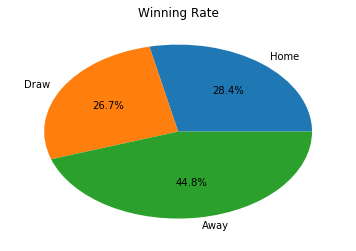

In [8]:
win_home = np.sum(games['FTR'] == 0)
draw = np.sum(games['FTR'] == 1)
win_away = np.sum(games['FTR'] == 2)
results_pie = [win_home, draw, win_away]
labels = ['Home', 'Draw', 'Away']
plt.title('Winning Rate')
plt.pie(results_pie, labels=labels, autopct='%1.1f%%')
plt.show()

In [9]:
X = games.drop(['FTHG', 'FTAG'], axis=1)

Y = games[['FTHG', 'FTAG']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
#X_train = scale(X_train)
#y_train = scale(y_train)
#X_test = scale(X_test)
#y_test = scale(y_test)
print(X_train.shape)
print(y_train.shape)

(8482, 25)
(8482, 2)


In [10]:
model = Sequential()

In [11]:
model.add(Dense(500, activation='relu', input_shape=(25,)))
model.add(Dropout(0.5))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               13000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               60120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 242       
Total params: 73,362
Trainable params: 73,362
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train,batch_size=8482, epochs=150,verbose=2, validation_data=(X_test, y_test))

Train on 8482 samples, validate on 3636 samples
Epoch 1/150
 - 0s - loss: 1.6252 - acc: 0.8755 - val_loss: 1.6088 - val_acc: 0.8801
Epoch 2/150
 - 0s - loss: 1.6249 - acc: 0.8822 - val_loss: 1.6088 - val_acc: 0.8754
Epoch 3/150
 - 0s - loss: 1.6246 - acc: 0.8825 - val_loss: 1.6088 - val_acc: 0.8735
Epoch 4/150
 - 0s - loss: 1.6249 - acc: 0.8767 - val_loss: 1.6088 - val_acc: 0.8776
Epoch 5/150
 - 0s - loss: 1.6248 - acc: 0.8796 - val_loss: 1.6088 - val_acc: 0.8740
Epoch 6/150
 - 0s - loss: 1.6253 - acc: 0.8792 - val_loss: 1.6087 - val_acc: 0.8790
Epoch 7/150
 - 0s - loss: 1.6243 - acc: 0.8819 - val_loss: 1.6088 - val_acc: 0.8721
Epoch 8/150
 - 0s - loss: 1.6243 - acc: 0.8797 - val_loss: 1.6088 - val_acc: 0.8743
Epoch 9/150
 - 0s - loss: 1.6254 - acc: 0.8797 - val_loss: 1.6088 - val_acc: 0.8790
Epoch 10/150
 - 0s - loss: 1.6250 - acc: 0.8810 - val_loss: 1.6088 - val_acc: 0.8707
Epoch 11/150
 - 0s - loss: 1.6251 - acc: 0.8735 - val_loss: 1.6088 - val_acc: 0.8872
Epoch 12/150
 - 0s - loss:

In [24]:
scores = model.evaluate(X_test, y_test, verbose=2)

In [25]:
print('Test Loss:', scores[0])
print('Test Accuracy', scores[1])

Test Loss: 1.60879783255
Test Accuracy 0.871562156084


Test Loss: 0.914881914449
Test Accuracy 0.990355107409


In [18]:
#prediction = model.predict()
#print(prediction)